# [Auditory modeling in PyTorch](https://github.com/msaddler/auditory_model_tutorial)

<a href="https://colab.research.google.com/github/msaddler/auditory_model_tutorial/blob/main/DEVELOPMENT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright (c) 2025 msaddler. MIT license.


## Setup

Import standard Python packages.

In [1]:
import glob
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import soundfile as sf
import torch
import torchaudio
import tqdm


If running this notebook in Google Colab, run the cell below to clone the [**`auditory_model_tutorial`**](https://github.com/msaddler/auditory_model_tutorial) repository into the current runtime and set it to be the working directory.

In [2]:
!git clone https://github.com/msaddler/auditory_model_tutorial.git
%cd auditory_model_tutorial
!ls -1


Cloning into 'auditory_model_tutorial'...
remote: Enumerating objects: 216, done.
remote: Counting objects: 100% (216/216), done.
remote: Compressing objects: 100% (187/187), done.
remote: Total 216 (delta 62), reused 177 (delta 29), pack-reused 0 (from 0)
Receiving objects: 100% (216/216), 22.66 MiB | 40.00 MiB/s, done.
Resolving deltas: 100% (62/62), done.
/rdma/vast-rdma/vast/mcdermott/msaddler/coursework/auditory_model_tutorial/auditory_model_tutorial
data
DEVELOPMENT.ipynb
filters.py
LICENSE
modules.py
pyproject.toml
README.md
requirements.txt
TUTORIAL.ipynb
utils.py


Import [**utils.py**](https://github.com/msaddler/auditory_model_tutorial/blob/main/utils.py) and [**modules.py**](https://github.com/msaddler/auditory_model_tutorial/blob/main/modules.py) as Python modules. These scripts contain useful functions and classes that can be called from this notebook once imported.

In [3]:
import utils
import modules


Check if a GPU (optional) is available in the current runtime and define the `device` variable.

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device


device(type='cuda', index=0)

## Introduction

This repository includes a small dataset of example sound files (speech waveforms stored as wav files), which can be loaded and played in the notebook.

In [5]:
list_filename = glob.glob("data/*.wav")
print(f"Found {len(list_filename)} wav files in the data directory")

filename = list_filename[0]
x, sr = sf.read(filename)  # Use `soundfile` package to load a wav file
print(f"Loaded `{filename}`: {x.shape=}, {x.dtype=}, {sr=} Hz")

ipd.display(ipd.Audio(rate=sr, data=x))


Found 100 wav files in the data directory
Loaded `data/000.wav`: x.shape=(40000,), x.dtype=dtype('float64'), sr=20000 Hz


The [**`utils`**](https://github.com/msaddler/auditory_model_tutorial/blob/main/utils.py) module contains helper functions for manipulating and visualizing audio signals. Use the `utils.make_spectrogram_plot` function to plot the sound waveform and spectrogram of the file loaded above.

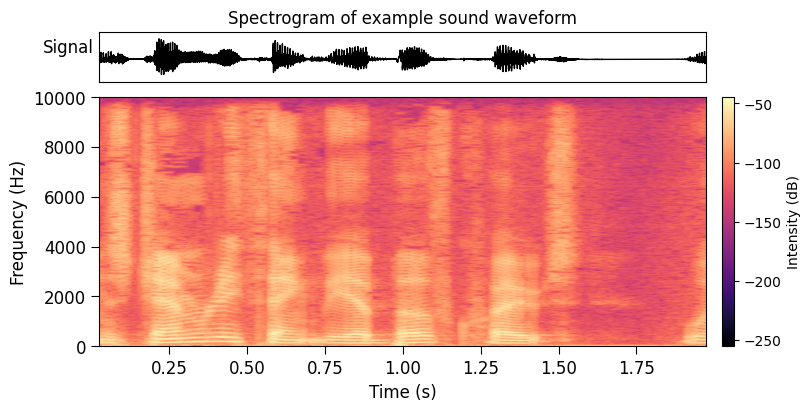

In [6]:
fig, ax = utils.make_spectrogram_plot(
    x,
    sr,
    figsize=(8, 4),
    # nfft=512,
    # noverlap=256,
    str_title="Spectrogram of example sound waveform",
)
plt.show()


The [**`utils`**](https://github.com/msaddler/auditory_model_tutorial/blob/main/utils.py) module also contains helper functions for generating simple audio signals. Here, we generate a harmonic complex tone, compute its power spectrum, and plot it on a log-scale frequency axis. The [**`matplotlib.pyplot`**](https://matplotlib.org/3.5.3/api/_as_gen/matplotlib.pyplot.html) Python package (abbreviated `plt`) offers a MATLAB-like API for plotting. I have provided the `utils.format_axes` helper function to set many axes-related parameters in a single call.

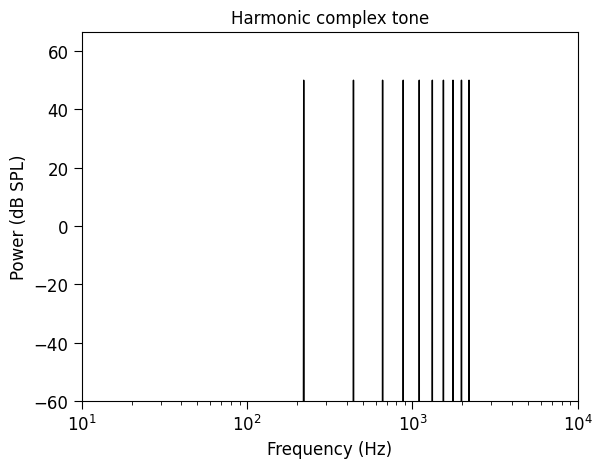

In [7]:
sr = 20e3
x = utils.harmonic_complex_tone(
    sr=sr,
    dur=0.5,
    f0=220,
    phase="sine",
    harmonics=np.arange(1, 11),
    amplitudes=1,
)
x = utils.set_dbspl(x, 60.0)  # Scale tone to have a sound level of 60 dB re 20e-6 Pa

ipd.display(ipd.Audio(rate=sr, data=x))

fig, ax = plt.subplots()
fxx, pxx = utils.periodogram(x, sr=sr, scaling="spectrum")
ax.plot(fxx, pxx, color="k", lw=1)
ax = utils.format_axes(
    ax,
    str_title="Harmonic complex tone",
    str_xlabel="Frequency (Hz)",
    str_ylabel="Power (dB SPL)",
    xscale="log",
    yscale="linear",
    xlimits=[10, sr / 2],
    ylimits=[-60, None],
)
plt.show()

# # Alternatively, use `utils.make_periodogram_plot` to plot the power spectrum
# fig, ax = utils.make_periodogram_plot(x, sr, str_title="Harmonic complex tone")
# plt.show()


So far, we have been considering sound waveforms as NumPy arrays, which are the fundamental datatype for numerical processing in Python. The fundamental datatype for PyTorch is the tensor. Tensors are similar to NumPy arrays, but include support for GPU-acceleration and automatic differentiation. Converting between NumPy arrays and Torch tensors is easy, but requires some attention to device placement and datatypes. PyTorch's [documentation](https://pytorch.org/tutorials/beginner/introyt/tensors_deeper_tutorial.html) offers a more comprehensive overview of tensors.


In [8]:
impulse_numpy = np.zeros(int(1.0 * sr))  # Initialize 1 second of zeros
impulse_numpy[0] = 1  # Set the first value to be 1 to make an impulse

# When defining a tensor, it is good practice to specify the device and the datatype
impulse_torch = torch.as_tensor(impulse_numpy, device=device, dtype=torch.float32)
print(impulse_torch)

impulse_torch.detach().cpu().numpy()  # Convert a tensor to a NumPy array


tensor([1., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')


array([1., 0., 0., ..., 0., 0., 0.], dtype=float32)

## Components of a PyTorch cochlear model

Tensors can be be processed with PyTorch functions and modules. In the [**`modules.py`**](https://github.com/msaddler/auditory_model_tutorial/blob/main/modules.py) script, I have implemented a `GammatoneFilterbank` class, which we will use as the first stage of our simple auditory nerve model.

Because PyTorch is designed for parallel numerical processing, this filterbank (like most models in PyTorch) expects *batched* rather than *single* inputs:
```
x.shape = [time]  <-- single input sound waveform
x.shape = [batch, time]  <-- batch of input sound waveforms
```

To run a single sound waveform through a model, we simply need to add a batch axis:
```
x = torch.zeros(n)  <-- has shape [n]
x = x[None, ...]  <-- has shape [1, n]
x = x[0, ...]  <-- back to shape [n]
```

As an alternative to this odd `[None, ...]` notation, you can also use `unsqueeze`/`squeeze`:
```
x = torch.zeros(n) <-- has shape [n]
x = x.unsqueeze(dim=0) <-- has shape [1, n]
x = x.squeeze(dim=0)  <-- back to shape [n]
```


In [9]:
# Our filterbank will have 50 center frequencies, spaced uniformly on an ERB scale
cfs = utils.erbspace(8e1, 8e3, 50)
# Construct the filterbank object with specified parameters
filterbank = modules.GammatoneFilterbank(
    sr=sr,
    fir_dur=0.05,  # Filterbank uses an FIR approximation (50 ms impulse responses is sufficient)
    cfs=cfs,
    dtype=torch.float32,
    bw_mult=1,
)
# Assign the filterbank object to a device
filterbank = filterbank.to(device)

# Apply the filterbank to our impulse tensor (note we added a batch axis)
impulse_response_torch = filterbank(impulse_torch[None, ...])
print(impulse_response_torch.shape)
# And remove the added batch axis to get an output with shape [freq, time]
impulse_response_torch = impulse_response_torch[0, ...]
print(impulse_response_torch.shape)


torch.Size([1, 50, 20000])
torch.Size([50, 20000])


Plot the power spectra of the filterbank's impulse responses. The `utils.make_periodogram_plot` function will plot the power spectrum of each frequency channel if the input has shape `[frequency_channels, time]`.

(50, 20000)


/rdma/vast-rdma/vast/mcdermott/msaddler/coursework/auditory_model_tutorial/auditory_model_tutorial/utils.py:97: RuntimeWarning: divide by zero encountered in log10
  pxx = 10.0 * np.log10(pxx / np.square(p_ref))


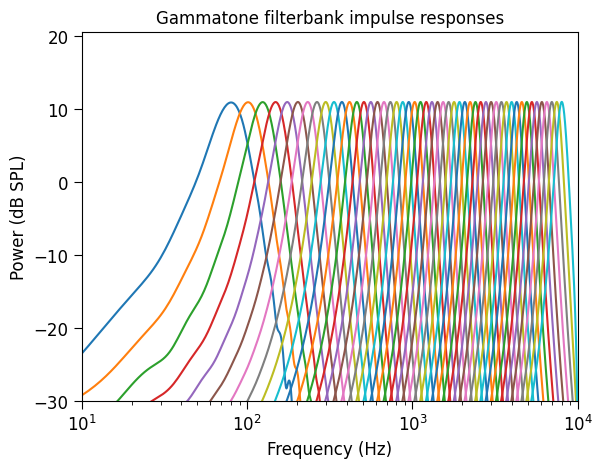

In [10]:
# First, convert the impulse response tensor to a NumPy array by detaching
# it from the torch graph, moving it to the CPU, and calling .numpy()
impulse_response = impulse_response_torch.detach().cpu().numpy()
print(impulse_response.shape)

fig, ax = utils.make_periodogram_plot(
    impulse_response,
    sr,
    str_title="Gammatone filterbank impulse responses",
    ylimits=[-30, None],
)
plt.show()


This linear filterbank approximates the **cochlea's frequency selectivity**. The input represents the instantaneous pressure of a sound waveform and the output represents the instantaneous displacement of the basilar membrane at different points along its length (i.e, the "cochlear frequency axis"). We can pass arbitrary sounds through this filterbank.

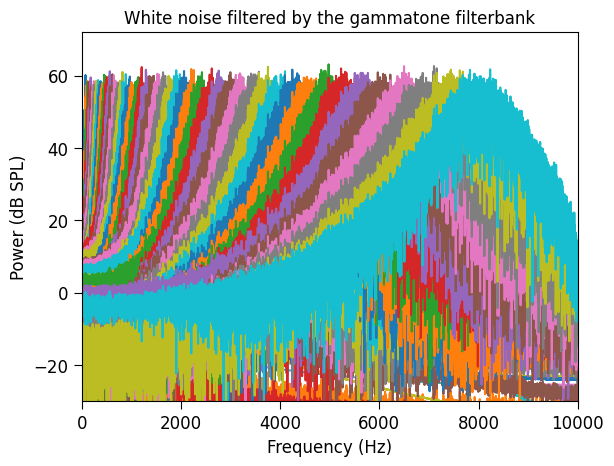

In [11]:
# Generate 1 second of white noise and plot the power spectra of the filtered subbands
x = torch.randn(1, int(sr), device=device, dtype=torch.float32)
y = filterbank(x)[0].detach().cpu().numpy()

fig, ax = utils.make_periodogram_plot(
    y,
    sr,
    str_title="White noise filtered by the gammatone filterbank",
    ylimits=[-30, None],
    xlimits=[0, sr / 2],
    xscale="linear",
)
plt.show()


The next stage of our peripheral auditory model is a very crude model of **inner hair cell (IHC) transduction**. Here, we simply use half-wave rectification to abstractly convert *instantaneous basilar membrane displacement* (the filterbank subbands) to *instantaneous IHC membrane potential* (the rectified subbands).

In NumPy / MATLAB, half-wave rectification is easily implemented as `x[x < 0] = 0`. In PyTorch, to avoid disrupting gradient tracking, we will use the `torch.nn.ReLU` class, which implements the "Rectified Linear Unit (ReLU)" activation function.

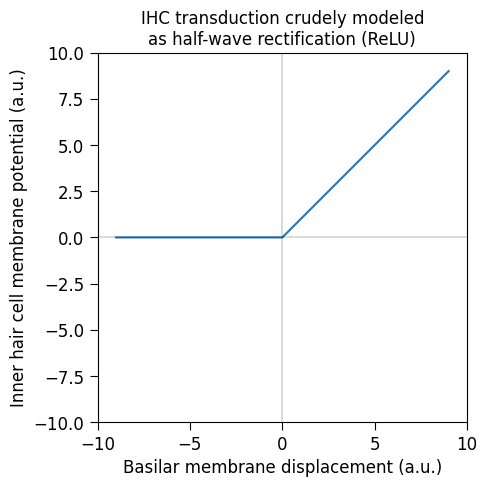

In [12]:
half_wave_rectification = torch.nn.ReLU()
x = np.arange(-9, 10)
x_rectified = half_wave_rectification(torch.as_tensor(x)).detach().cpu().numpy()

fig, ax = plt.subplots()
ax.plot(x, x_rectified)
ax.axvline(0, color="k", lw=0.2)
ax.axhline(0, color="k", lw=0.2)
ax.axis("square")
utils.format_axes(
    ax,
    xlimits=[-10, 10],
    ylimits=[-10, 10],
    str_xlabel="Basilar membrane displacement (a.u.)",
    str_ylabel="Inner hair cell membrane potential (a.u.)",
    str_title="IHC transduction crudely modeled\nas half-wave rectification (ReLU)",
)
plt.show()


To more accurately model the IHC membrane potential, we also need to apply a low-pass filter.

The **IHC membrane potential** is sluggish relative to the mechanical vibration of the basilar membrane. At low frequencies, the IHC potential tracks the individual oscillations of the basilar membrane, but at higher frequencies the IHC potential cannot keep up. The IHC membrane acts as a lowpass filter that restricts the upper frequency limit of phase locking in the auditory nerve.

The `modules.IHCLowpassFilter` class implements a low-pass filter that can operate on inputs with shape `[batch, time]` or `[batch, freq, time]`. In the latter case, the same filter is applied along the time axis to each frequency channel.


(20000,)


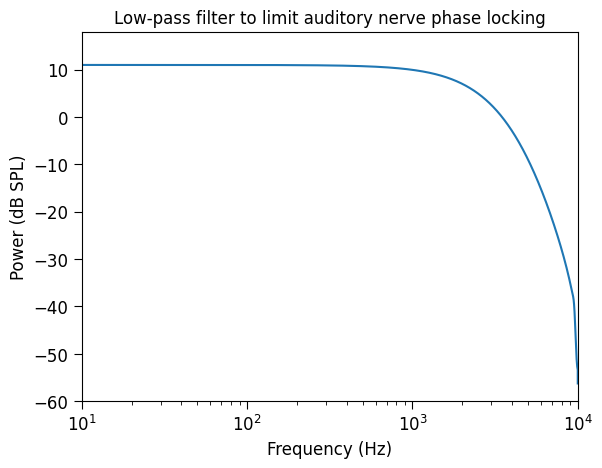

In [13]:
ihc_lowpass_filter = modules.IHCLowpassFilter(
    sr_input=sr,
    sr_output=sr,
    fir_dur=0.05,
    cutoff=3e3,
    order=7,
).to(device)

impulse_response_torch = ihc_lowpass_filter(impulse_torch[None, ...])[0]
impulse_response = impulse_response_torch.detach().cpu().numpy()
print(impulse_response.shape)

fig, ax = utils.make_periodogram_plot(
    impulse_response,
    sr,
    str_title="Low-pass filter to limit auditory nerve phase locking",
)
plt.show()


The last stage of the simple peripheral model will convert the half-wave rectified and low-pass filtered subbands to **instantaneous auditory nerve firing rates**. This is accomplished with a sigmoid function whose threshold and dynamic range can be set in dB SPL. Applying a sigmoid function at the output lets us crudely model loss of audibility at low sound levels and saturation at high sound levels.

The parameters of this rate-level function are somewhat arbitrary and  ignore much of the complexity of real auditory nerve fibers. Here, we make some simplifying (and incorrect) assumptions about a population of healthy auditory nerve fibers:
- Threshold = 0 dB SPL
- Dynamic range = 80 dB
- Spontaneous activity = 0 spikes/s
- Maximum activity = 250 spikes/s


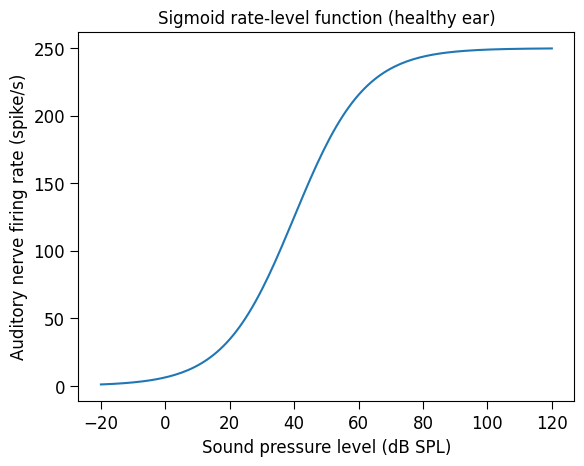

In [14]:
fig, ax = plt.subplots()
rate_level_function = modules.SigmoidRateLevelFunction(
    rate_spont=0.0,
    rate_max=250.0,
    threshold=0.0,
    dynamic_range=80.0,
    dynamic_range_interval=0.95,
    dtype=torch.float32,
).to(device)
x_db = np.arange(-20, 121)
x_pa = 20e-6 * (10 ** (x_db / 20))
x_pa_torch = torch.as_tensor(
    x_pa,
    device=device,
    dtype=torch.float32,
)
y_torch = rate_level_function(x_pa_torch[None, None, :])[0, 0, :]
y = y_torch.detach().cpu().numpy()
ax.plot(x_db, y)
ax = utils.format_axes(
    ax,
    str_xlabel="Sound pressure level (dB SPL)",
    str_ylabel="Auditory nerve firing rate (spike/s)",
    str_title="Sigmoid rate-level function (healthy ear)",
)
plt.show()


In the healthy ear, **outer hair cells (OHCs) act as a cochlear amplifier**, boosting responses to quiet sounds. Sensorineural hearing loss often involves the death or dysfunction of OHCs, resulting in reduced sensitivity to quiet sounds (elevated thresholds) and a smaller dynamic range. We can simulate these effects by adjusting the rate-level function parameters.

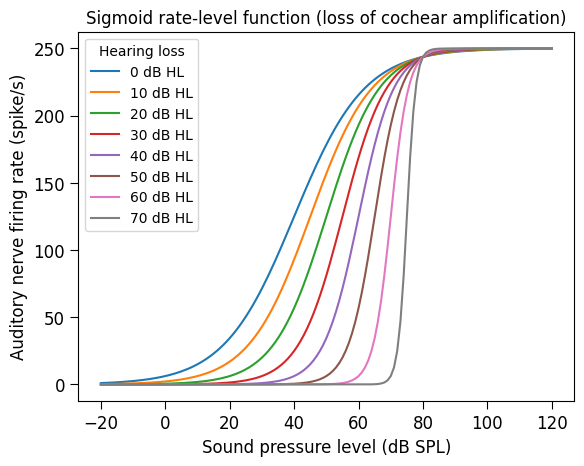

In [15]:
fig, ax = plt.subplots()
healthy_threshold = 0.0
healthy_dynamic_range = 80.0
for dbhl in np.arange(0, 75, 10):
    rate_level_function = modules.SigmoidRateLevelFunction(
        rate_spont=0.0,
        rate_max=250.0,
        threshold=healthy_threshold + dbhl,  # Simply increase the threshold
        dynamic_range=healthy_dynamic_range - dbhl,  # And decrease the dynamic range
        dtype=torch.float32,
    ).to(device)
    x_db = np.arange(-20, 121)
    x_pa = 20e-6 * (10 ** (x_db / 20))
    x_pa_torch = torch.as_tensor(
        x_pa,
        device=device,
        dtype=torch.float32,
    )
    y_torch = rate_level_function(x_pa_torch[None, None, :])[0, 0, :]
    y = y_torch.detach().cpu().numpy()
    ax.plot(x_db, y, label=f"{dbhl} dB HL")
ax.legend(title="Hearing loss")
ax = utils.format_axes(
    ax,
    str_xlabel="Sound pressure level (dB SPL)",
    str_ylabel="Auditory nerve firing rate (spike/s)",
    str_title="Sigmoid rate-level function (loss of cochear amplification)",
)
plt.show()


## Assembling the full cochlear model

Now that we have examined each of the cochlear model stages individually, it is time to assemble the full cochlear model into a single PyTorch module.

A skeleton for the `CochlearModel` class is provided below. If you are familiar with Python classes, you will notice the skeleton is subclassing [**`torch.nn.Module`**](https://pytorch.org/docs/stable/generated/torch.nn.Module.html), which is the base class for all models in PyTorch.

Because our model is a subclass of `torch.nn.Module`, we only need to implement two methods to obtain a fully-functioning PyTorch model. The `__init__` method sets up the model and is where you should define each of the model components as an attribute (e.g., `self.cochlear_filterbank = ...`). The `forward` method defines the computations that should be performed each time the model is called. Your `forward` pass should successively apply the model components defined in the `__init__` method.

The convenience of PyTorch is that if we want to compute gradients from or through our model, we do not need to implement the `backward` pass ourselves. The derivatives will all be computed / tracked automatically!


In [16]:
class CochlearModel(torch.nn.Module):
    def __init__(
        self,
        sr_input=20000,
        sr_output=10000,
        fir_dur=0.05,
        cfs=utils.erbspace(8e1, 8e3, 100),
        bw_mult=1.0,
        threshold=0.0,
        dynamic_range=80.0,
        dtype=torch.float32,
    ):
        """
        Simple cochlear model in PyTorch.

        Args
        ----
        sr_input (int): sampling rate of the input sound waveform
        sr_output (int): sampling rate of the output representation
        fir_dur (float): duration of finite impulse responses for filtering (s)
        cfs (np.ndarray): characteristic frequencies of the cochlear filters (Hz)
        bw_mult (float): scaling factor applied to cochlear filter bandwidths
        threshold (float): absolute threshold of auditory nerve fibers (dB SPL)
        dynamic_range (float): auditory nerve fiber dynamic range (dB)
        dtype (torch.dtype): datatype for internal intensors and inputs
        """
        super().__init__()
        self.sr_input = sr_input
        self.sr_output = sr_output
        self.cfs = cfs
        self.cochlear_filterbank = modules.GammatoneFilterbank(
            sr=sr_input,
            fir_dur=fir_dur,
            cfs=self.cfs,
            dtype=dtype,
            bw_mult=bw_mult,
        )
        self.half_wave_rectification = torch.nn.ReLU()
        self.ihc_lowpass_filter = modules.IHCLowpassFilter(
            sr_input=sr_input,
            sr_output=sr_output,
            fir_dur=fir_dur,
            cutoff=3e3,
            order=7,
        )
        self.rate_level_function = modules.SigmoidRateLevelFunction(
            rate_spont=0.0,
            rate_max=250.0,
            threshold=threshold,
            dynamic_range=dynamic_range,
            dynamic_range_interval=0.95,
            dtype=dtype,
        )

    def forward(self, x):
        """
        Run the cochlear model on a batch of input sound waveforms.

        Args
        ----
        x (torch.Tensor): input sound waveforms with shape [batch, time]

        Returns
        -------
        x (torch.Tensor): output of cochlear model with shape [batch, freq, time]
        """
        x = self.cochlear_filterbank(x)
        x = self.half_wave_rectification(x)
        x = self.ihc_lowpass_filter(x)
        x = self.half_wave_rectification(x)
        x = self.rate_level_function(x)
        return x


debug_cochlear_model = CochlearModel()
debug_input = torch.randn(1, 1000)
debug_output = debug_cochlear_model(debug_input)
print(f"{debug_input.shape=}, {debug_output.shape=}")


debug_input.shape=torch.Size([1, 1000]), debug_output.shape=torch.Size([1, 100, 500])


Test your cochlear model implementation in the cell below:

1. Construct a `cochlear_model` object with a call to the `CochlearModel` class
2. Generate or load a sound waveform `x`
3. Convert `x` to a tensor with shape `[batch=1, time]`
4. Apply `cochlear_model` to `x` to produce `x_nervegram` with shape `[batch=1, freq, time]`
5. Convert `x_nervegram` to a NumPy array with shape `[freq, time]`
6. Visualize `x_nervegram` using `utils.make_nervegram_plot`

(100, 500)


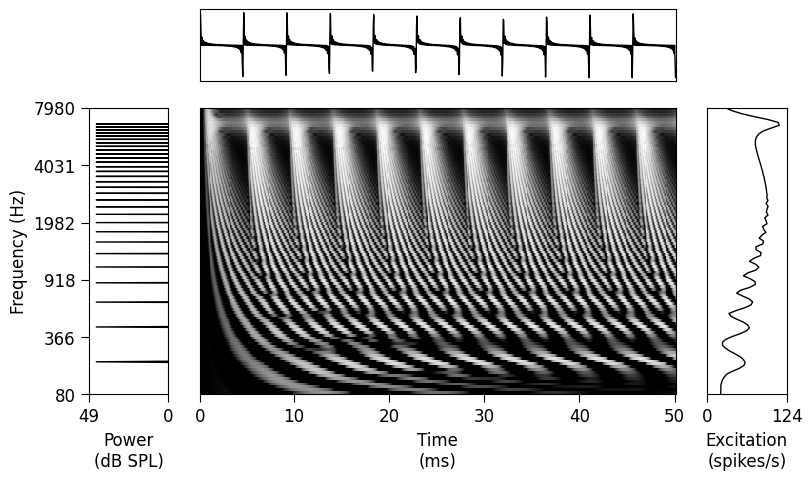

In [17]:
cochlear_model = CochlearModel(
    sr_input=20e3,
    sr_output=10e3,
    cfs=utils.erbspace(8e1, 8e3, 100),
).to(device)

x = utils.harmonic_complex_tone(
    sr=cochlear_model.sr_input,
    dur=0.05,
    f0=220,
    phase="sine",
    harmonics=np.arange(1, 31, 1),
)
x = utils.set_dbspl(x, 60)
# x, _ = sf.read("data/000.wav")

x_tensor = torch.as_tensor(x, device=device, dtype=torch.float32)[None, ...]
x_nervegram_tensor = cochlear_model(x_tensor)[0]
x_nervegram = x_nervegram_tensor.detach().cpu().numpy()
print(x_nervegram.shape)

fig, ax_arr = utils.make_nervegram_plot(
    waveform=x,
    nervegram=x_nervegram,
    sr_waveform=cochlear_model.sr_input,
    sr_nervegram=cochlear_model.sr_output,
    cfs=cochlear_model.cfs,
)
plt.show()


Get a sense for how fast the cochlear model can run on the current device.

In [18]:
progress_bar = tqdm.tqdm(range(200))  # tqdm.tqdm wraps an iterable and displays a progress bar
for itr in progress_bar:
    x_nervegram_tensor = cochlear_model(x_tensor)
    progress_bar.set_postfix({"current_iteration": itr})


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1344.96it/s, current_iteration=199]


## Hearing loss simulation

Simulate the peripheral consequences of hearing loss by adjusting the cochlear model parameters. Visualize the effect on the resulting auditory nerve representations.

Healthy cochlear model


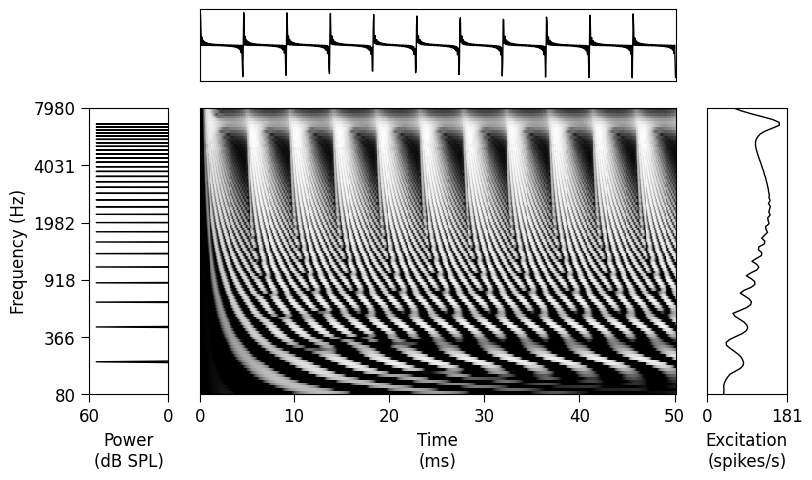

Impaired cochlear model


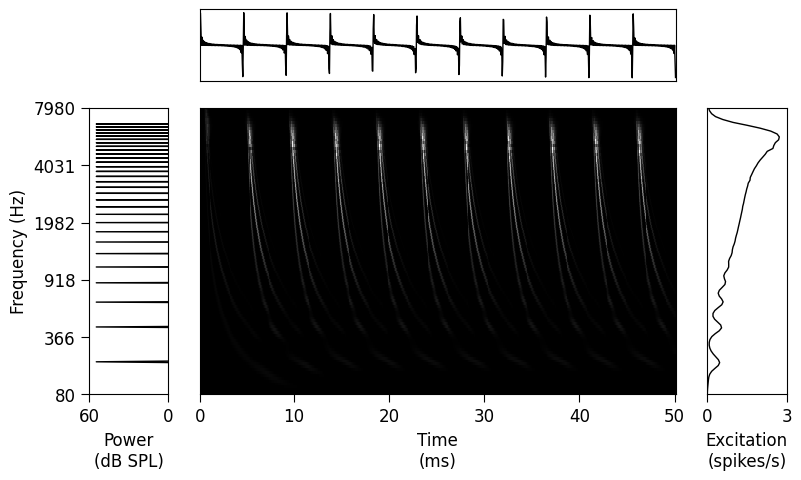

In [19]:
cfs = utils.erbspace(8e1, 8e3, 100)

# Construct a healthy cochlear model
cochlear_model_healthy = CochlearModel(
    sr_input=sr,
    cfs=cfs,
    threshold=0.0,
    dynamic_range=80.0,
    bw_mult=1.0,
).to(device)

# Construct an impaired cochlear model
cochlear_model_impaired = CochlearModel(
    sr_input=sr,
    cfs=cfs,
    threshold=60.0,  # Elevated thresholds
    dynamic_range=20.0,  # Reduced dynamic range
    bw_mult=2.0,  # Broader cochlear frequency tuning
).to(device)

# Define a stimulus to play to both cochlear models
x = utils.harmonic_complex_tone(
    sr=cochlear_model_healthy.sr_input,
    dur=0.05,
    f0=220,
    phase="sine",
    harmonics=np.arange(1, 31, 1),
)
x = utils.set_dbspl(x, 70)

# Run the stimulus through both cochlear models
x_tensor = torch.as_tensor(x, device=device, dtype=torch.float32)[None, ...]
x_nervegram_healthy = cochlear_model_healthy(x_tensor)[0].detach().cpu().numpy()
x_nervegram_impaired = cochlear_model_impaired(x_tensor)[0].detach().cpu().numpy()

# Visualize both auditory nerve representations
print("Healthy cochlear model")
fig, ax_arr = utils.make_nervegram_plot(
    waveform=x,
    nervegram=x_nervegram_healthy,
    sr_waveform=cochlear_model_healthy.sr_input,
    sr_nervegram=cochlear_model_healthy.sr_output,
    cfs=cochlear_model_healthy.cfs,
)
plt.show()
print("Impaired cochlear model")
fig, ax_arr = utils.make_nervegram_plot(
    waveform=x,
    nervegram=x_nervegram_impaired,
    sr_waveform=cochlear_model_healthy.sr_input,
    sr_nervegram=cochlear_model_healthy.sr_output,
    cfs=cochlear_model_healthy.cfs,
)
plt.show()


## Hearing aid optimization objective

A reasonable objective for a hearing aid would be to process audio in such a way that the auditory nerve representation of an impaired ear is maximally similar to that of a healthy ear. How can we implement this notion quantitatively as a *loss function*?

Define a `loss_function` that takes as input an unprocessed sound waveform `x` and a processed sound_waveform `x_aided`. The function should return some [**measure of distance**](https://pytorch.org/docs/stable/nn.functional.html#loss-functions) between the healthy auditory nerve representation of `x` and the impaired auditory nerve representation of `x_aided`.


In [20]:
def loss_function(x, x_aided):
    y_healthy = cochlear_model_healthy(x)
    y_impaired = cochlear_model_impaired(x_aided)
    loss = torch.nn.functional.mse_loss(y_impaired, y_healthy)
    return loss


We will first consider the **simplest possible hearing aid**: linear amplification applied to the entire sound waveform. Here, there is only a single parameter to optimize (the gain), so we can easily find the optimal value with brute force.

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 799.25it/s]


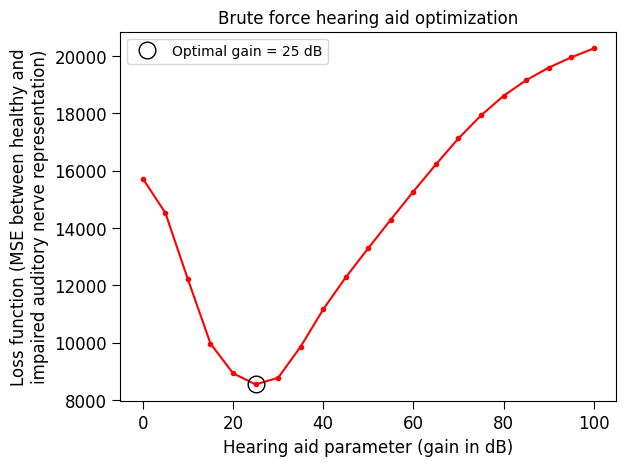

In [21]:
list_db_gain = np.arange(0, 101, 5)
list_loss = []
for db_gain in tqdm.tqdm(list_db_gain):
    amp = np.power(10, db_gain / 20)
    loss = loss_function(
        x=x_tensor,
        x_aided=amp * x_tensor,
    ).item()
    list_loss.append(loss)

best_db_gain = list_db_gain[np.argmin(list_loss)]

fig, ax = plt.subplots()
ax.plot(list_db_gain, list_loss, marker=".", color="r", ls="-")
ax.plot(
    best_db_gain,
    np.min(list_loss),
    marker="o",
    ms=12,
    ls="",
    mfc="none",
    color="k",
    label=f"Optimal gain = {best_db_gain} dB",
)
ax.legend()
utils.format_axes(
    ax,
    str_title="Brute force hearing aid optimization",
    str_xlabel="Hearing aid parameter (gain in dB)",
    str_ylabel="Loss function (MSE between healthy and\nimpaired auditory nerve representation)",
)
plt.show()


Visualize the resulting auditory nerve representations.

Healthy cochlear model with unprocessed input


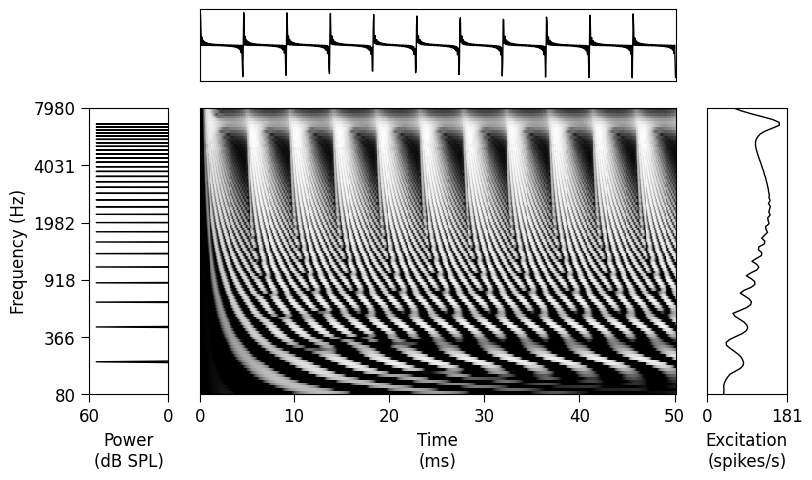

Impaired cochlear model with aided input


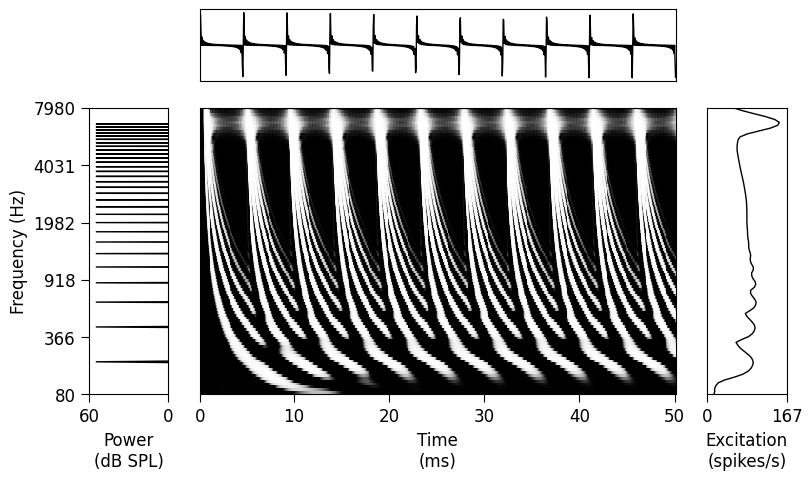

In [22]:
best_amp = np.power(10, best_db_gain / 20)

x_tensor = torch.as_tensor(x, device=device, dtype=torch.float32)[None, ...]
x_nervegram_healthy = cochlear_model_healthy(x_tensor)[0].detach().cpu().numpy()
x_nervegram_impaired = cochlear_model_impaired(best_amp * x_tensor)[0].detach().cpu().numpy()

print("Healthy cochlear model with unprocessed input")
fig, ax_arr = utils.make_nervegram_plot(
    waveform=x,
    nervegram=x_nervegram_healthy,
    sr_waveform=cochlear_model_healthy.sr_input,
    sr_nervegram=cochlear_model_healthy.sr_output,
    cfs=cochlear_model_healthy.cfs,
)
plt.show()
print("Impaired cochlear model with aided input")
fig, ax_arr = utils.make_nervegram_plot(
    waveform=x,
    nervegram=x_nervegram_impaired,
    sr_waveform=cochlear_model_impaired.sr_input,
    sr_nervegram=cochlear_model_impaired.sr_output,
    cfs=cochlear_model_impaired.cfs,
)
plt.show()


Real hearing losses are rarely uniform across all frequencies. How can we compensate for a more plausible frequency-dependent hearing loss?

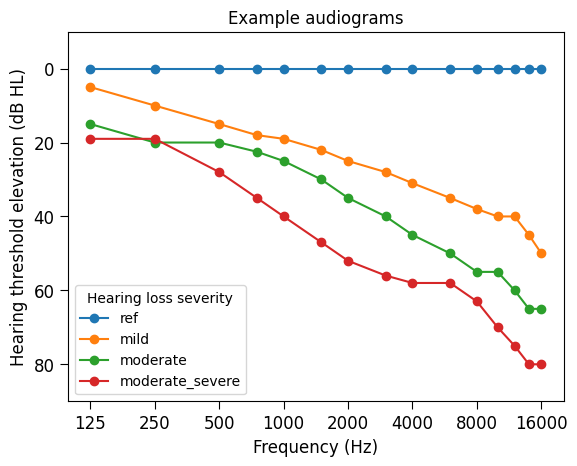

In [23]:
fig, ax = plt.subplots()
for severity in ["ref", "mild", "moderate", "moderate_severe"]:
    freq, dbhl = utils.get_example_audiogram(severity)
    ax.plot(freq, dbhl, marker="o", label=severity)
ax.legend(title="Hearing loss severity")
ax = utils.format_axes(
    ax,
    xscale="log",
    ylimits=[90, -10],
    xticks=[125, 250, 500, 1000, 2000, 4000, 8000, 16000],
    xticklabels=[125, 250, 500, 1000, 2000, 4000, 8000, 16000],
    xticks_minor=[],
    str_xlabel="Frequency (Hz)",
    str_ylabel="Hearing threshold elevation (dB HL)",
    str_title="Example audiograms",
)
plt.show()


Construct a new impaired cochlear model that better approximates a realistic hearing-impaired audiogram. Here we set the model's `threshold` and `dynamic_range` as frequency-specific arrays with the same shape as `cfs`.

cfs.shape=(100,), threshold.shape=(100,), dynamic_range.shape=(100,)


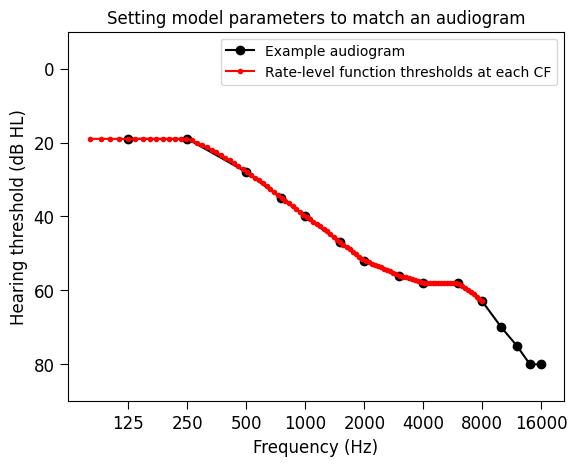

In [24]:
freq, dbhl = utils.get_example_audiogram(severity="moderate_severe")
threshold, dynamic_range = utils.map_audiogram_to_rate_level_parameters(
    freq=freq,
    dbhl=dbhl,
    cfs=cfs,
    healthy_threshold=healthy_threshold,
    healthy_dynamic_range=healthy_dynamic_range,
)
print(f"{cfs.shape=}, {threshold.shape=}, {dynamic_range.shape=}")
cochlear_model_impaired = CochlearModel(
    sr_input=sr,
    cfs=cfs,
    threshold=threshold,
    dynamic_range=dynamic_range,
    bw_mult=1.0,  # Neglecting broader frequency tuning for now
).to(device)

fig, ax = plt.subplots()
ax.plot(freq, dbhl, marker="o", color="k", label="Example audiogram")
ax.plot(
    cochlear_model_impaired.cfs,
    cochlear_model_impaired.rate_level_function.threshold,
    marker=".",
    color="r",
    label="Rate-level function thresholds at each CF",
)
ax.legend()
ax = utils.format_axes(
    ax,
    xscale="log",
    ylimits=[90, -10],
    xticks=[125, 250, 500, 1000, 2000, 4000, 8000, 16000],
    xticklabels=[125, 250, 500, 1000, 2000, 4000, 8000, 16000],
    xticks_minor=[],
    str_xlabel="Frequency (Hz)",
    str_ylabel="Hearing threshold (dB HL)",
    str_title="Setting model parameters to match an audiogram",
)
plt.show()


## Hearing aid with frequency-dependent amplification

One possibility is to build a hearing aid with frequency-specific gains. We can filter the input sound into different frequency channels, scale the channels with separate gains, and then sum the channels back together. The `modules.HalfCosineFilterbank` class is a reasonable filterbank for decomposing and reconstructing audio in this way.

(7, 20000)


/rdma/vast-rdma/vast/mcdermott/msaddler/coursework/auditory_model_tutorial/auditory_model_tutorial/modules.py:248: RuntimeWarning: divide by zero encountered in log
  f = np.log(f)


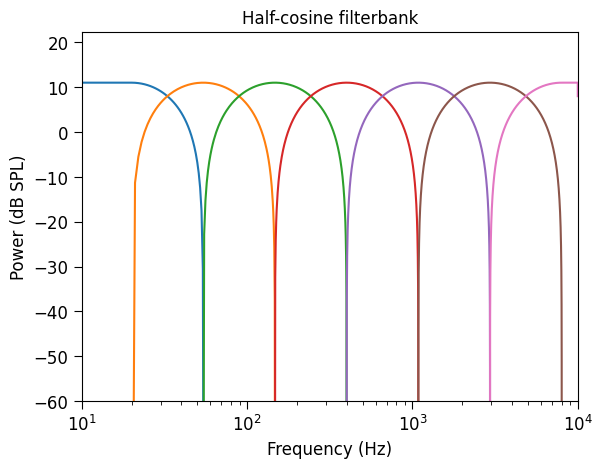

In [25]:
filterbank = modules.HalfCosineFilterbank(
    sr=sr,
    cf_low=20,
    cf_high=8000,
    cf_num=7,
    scale="log",
    include_highpass=True,
    include_lowpass=True,
).to(device)

impulse_response_torch = filterbank(impulse_torch[None, ...])[0]
impulse_response = impulse_response_torch.detach().cpu().numpy()
print(impulse_response.shape)

fig, ax = utils.make_periodogram_plot(
    impulse_response,
    sr,
    str_title="Half-cosine filterbank",
)
plt.show()


Since hearing aids can have many tunable parameters (e.g., frequency-specific gains), we need a more scalable optimization method than brute force. Implementing a hearing aid as a PyTorch model with learnable parameters unlocks the tools of machine learning -- we can use *gradient descent* to efficiently find parameter values that minimize our loss function.

Complete the `HearingAid` model class below. The `__init__` method has already been implemented. Only the `forward` method needs to be filled in.


In [26]:
class HearingAid(torch.nn.Module):
    def __init__(self, sr=20e3, channels=7):
        """
        Initialize the hearing aid model.
        """
        super().__init__()
        self.filterbank = modules.HalfCosineFilterbank(
            sr=sr,
            cf_low=20,
            cf_high=sr / 2,
            cf_num=channels,
            scale="log",
            include_highpass=True,
            include_lowpass=True,
        )
        self.gains_db = torch.nn.parameter.Parameter(
            data=torch.zeros(1, self.filterbank.cf_num, 1),
            requires_grad=True,
        )

    def forward(self, x):
        """
        Apply the computations to an input sound `x`.
        """
        y = self.filterbank(x)
        y = y * torch.pow(10, self.gains_db / 20)
        y = torch.sum(y, axis=1)
        return y


debug_cochlear_model = CochlearModel()
debug_input = torch.randn(1, 1000)
debug_output = debug_cochlear_model(debug_input)
print(f"{debug_input.shape=}, {debug_output.shape=}")


debug_input.shape=torch.Size([1, 1000]), debug_output.shape=torch.Size([1, 100, 500])


Test your `HearingAid` implementation by visualizing the impulse reponse.

HearingAid(
  (filterbank): HalfCosineFilterbank()
)
gains_db Parameter containing:
tensor([[[0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]]], device='cuda:0', requires_grad=True)


/rdma/vast-rdma/vast/mcdermott/msaddler/coursework/auditory_model_tutorial/auditory_model_tutorial/utils.py:97: RuntimeWarning: divide by zero encountered in log10
  pxx = 10.0 * np.log10(pxx / np.square(p_ref))


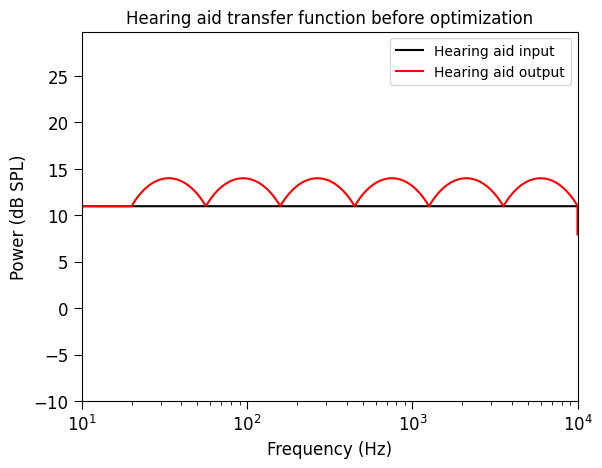

In [27]:
hearing_aid = HearingAid(sr=sr, channels=7).to(device)
# hearing_aid.gains_db = torch.nn.Parameter(
#     5 * torch.randn(*hearing_aid.gains_db.shape, device=device, dtype=torch.float32),
# )
print(hearing_aid)
for n, p in hearing_aid.named_parameters():
    print(n, p)

impulse_response_torch = hearing_aid(impulse_torch[None, ...])[0]
impulse_response = impulse_response_torch.detach().cpu().numpy()

fig, ax = plt.subplots()
fxx, pxx = utils.periodogram(impulse_numpy, sr)
fyy, pyy = utils.periodogram(impulse_response, sr)
ax.plot(fxx, pxx, color="k", label="Hearing aid input")
ax.plot(fyy, pyy, color="r", label="Hearing aid output")
ax.legend()
utils.format_axes(
    ax,
    xscale="log",
    xlimits=[10, sr / 2],
    ylimits=[-10, None],
    str_xlabel="Frequency (Hz)",
    str_ylabel="Power (dB SPL)",
    str_title="Hearing aid transfer function before optimization",
)
plt.show()


## Gradient-based hearing aid optimization 

We will optimize the parameters of the hearing aid using gradient descent to minimize our loss function.

**This cell will run extremely slowly without GPU acceleration**. If a GPU is not available, use a smaller dataset by truncating the number of examples and/or the length of the stimuli.


In [28]:
# Define the dataset (for time, we use only a small batch of speech signals)
x = np.stack(
    [sf.read("data/{:03d}.wav".format(_))[0] for _ in range(8)],
    axis=0,
)
x = torch.as_tensor(x, device=device, dtype=torch.float32)
print(f"Dataset shape: {x.shape}")

# Define a PyTorch optimizer object and tell it which parameters to update
optimizer = torch.optim.Adam(
    params=list(hearing_aid.parameters()),
    lr=1e-1,  # The learning rate is a hyperparameter (determines gradient descent step size)
)

# In the optimization loop, we iteratively compute the loss,
# calculate the gradients with `loss.backward()`, and then
# call `optimizer.step()` to update the parameters.
progress_bar = tqdm.tqdm(range(500))
for step in progress_bar:
    optimizer.zero_grad()
    x_aided = hearing_aid(x)
    loss = loss_function(x=x, x_aided=x_aided)
    loss.backward()
    optimizer.step()
    progress_bar.set_postfix({"loss": "{:0.4f}".format(loss.item())})

print("hearing_aid parameters after optimization:")
for n, p in hearing_aid.named_parameters():
    print(n, p)


Dataset shape: torch.Size([8, 40000])


  0%|                                                                                                                                             | 0/500 [00:00<?, ?it/s]/rdma/vast-rdma/vast/mcdermott/msaddler/coursework/auditory_model_tutorial/auditory_model_tutorial/modules.py:248: RuntimeWarning: divide by zero encountered in log
  f = np.log(f)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:54<00:00,  9.12it/s, loss=397.9666]

hearing_aid parameters after optimization:
gains_db Parameter containing:
tensor([[[10.5685],
         [ 6.2024],
         [ 7.4652],
         [10.3831],
         [21.3365],
         [31.3333],
         [26.6983]]], device='cuda:0', requires_grad=True)


Visualize the optimized hearing aid's signal processing.

/rdma/vast-rdma/vast/mcdermott/msaddler/coursework/auditory_model_tutorial/auditory_model_tutorial/utils.py:97: RuntimeWarning: divide by zero encountered in log10
  pxx = 10.0 * np.log10(pxx / np.square(p_ref))


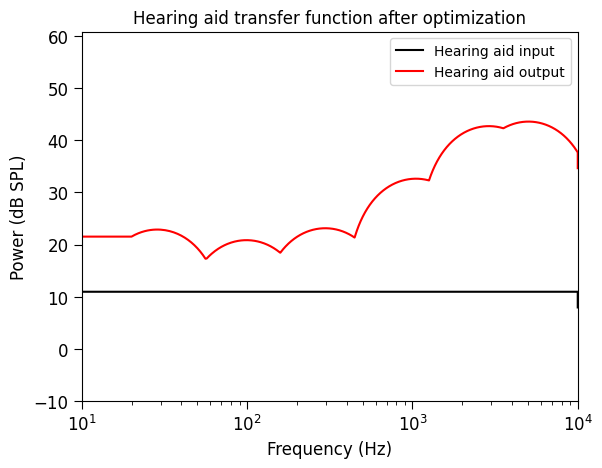

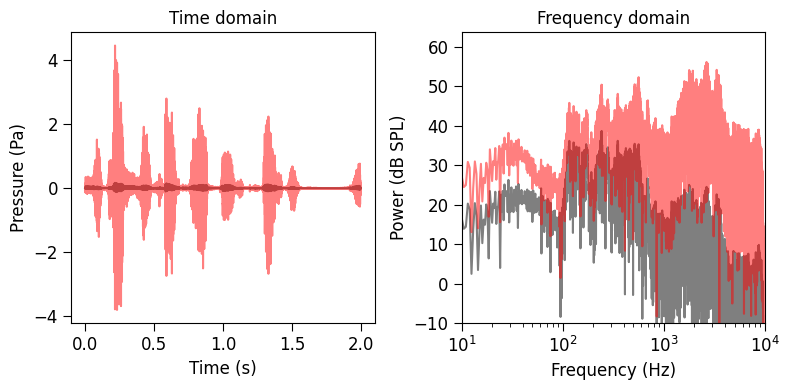

In [29]:
impulse_response_torch = hearing_aid(impulse_torch[None, ...])[0]
impulse_response = impulse_response_torch.detach().cpu().numpy()

fig, ax = plt.subplots()
fxx, pxx = utils.periodogram(impulse_numpy, sr)
fyy, pyy = utils.periodogram(impulse_response, sr)
ax.plot(fxx, pxx, color="k", label="Hearing aid input")
ax.plot(fyy, pyy, color="r", label="Hearing aid output")
ax.legend()
utils.format_axes(
    ax,
    xscale="log",
    xlimits=[10, sr / 2],
    ylimits=[-10, None],
    str_xlabel="Frequency (Hz)",
    str_ylabel="Power (dB SPL)",
    str_title="Hearing aid transfer function after optimization",
)
plt.show()

example_audio = torch.as_tensor(
    sf.read("data/000.wav".format(_))[0][None, :],
    device=device,
    dtype=torch.float32,
)

example_audio_aided = hearing_aid(example_audio)
example_audio = example_audio[0].detach().cpu().numpy()
example_audio_aided = example_audio_aided[0].detach().cpu().numpy()

fig, ax_arr = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
t = np.arange(0, len(example_audio)) / sr
ax_arr[0].plot(t, example_audio, color="k", alpha=0.5)
ax_arr[0].plot(t, example_audio_aided, color="r", alpha=0.5)
ax_arr[0] = utils.format_axes(
    ax_arr[0],
    str_xlabel="Time (s)",
    str_ylabel="Pressure (Pa)",
    str_title="Time domain",
)
fxx, pxx = utils.periodogram(example_audio, sr)
fyy, pyy = utils.periodogram(example_audio_aided, sr)
ax_arr[1].plot(fxx, pxx, color="k", alpha=0.5)
ax_arr[1].plot(fyy, pyy, color="r", alpha=0.5)
ax_arr[1] = utils.format_axes(
    ax_arr[1],
    xscale="log",
    xlimits=[10, sr / 2],
    ylimits=[-10, None],
    str_xlabel="Frequency (Hz)",
    str_ylabel="Power (dB SPL)",
    str_title="Frequency domain",
)
plt.tight_layout()
plt.show()

ipd.display(ipd.Audio(rate=sr, data=example_audio))
ipd.display(ipd.Audio(rate=sr, data=example_audio_aided))


Visualize the resulting auditory nerve representations.

Healthy cochlear model with unprocessed input


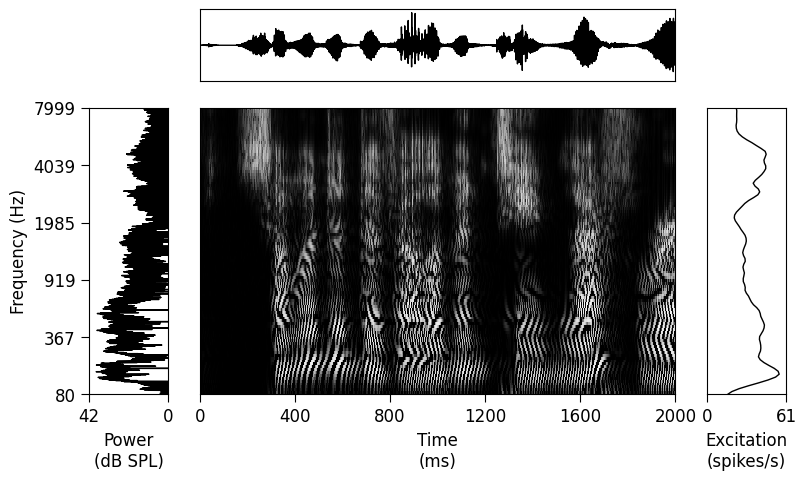

Impaired cochlear model with unprocessed input


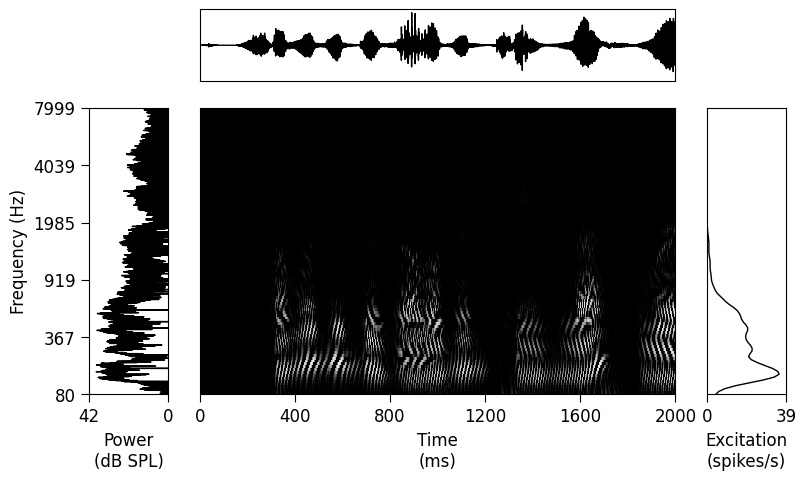

Impaired cochlear model with aided input


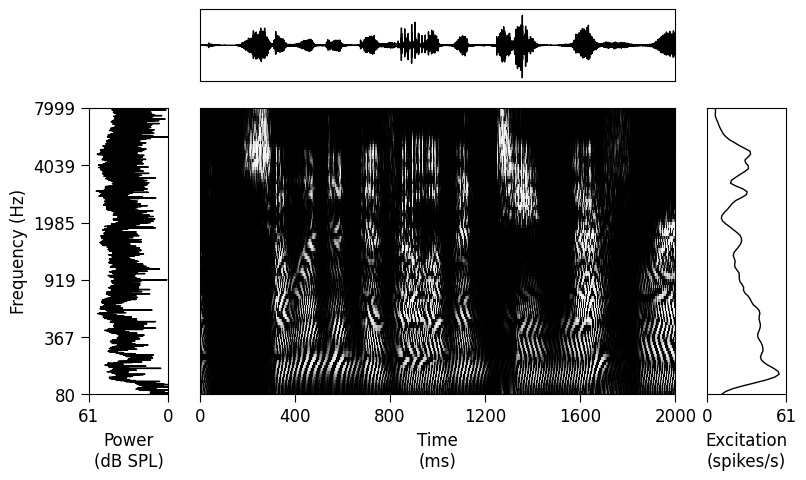

In [30]:
# x = utils.harmonic_complex_tone(
#     sr=sr,
#     dur=0.05,
#     f0=220,
#     phase="sine",
#     harmonics=np.arange(1, 31),
# )
# x = utils.set_dbspl(x, 60.0)
x, _ = sf.read("data/099.wav")

x = torch.as_tensor(x[None, ...], device=device, dtype=torch.float32)
x_aided = hearing_aid(x)
x_nervegram_healthy = cochlear_model_healthy(x)[0].detach().cpu().numpy()
x_nervegram_impaired = cochlear_model_impaired(x)[0].detach().cpu().numpy()
x_nervegram_impaired_aided = cochlear_model_impaired(x_aided)[0].detach().cpu().numpy()
x = x[0].detach().cpu().numpy()
x_aided = x_aided[0].detach().cpu().numpy()

print("Healthy cochlear model with unprocessed input")
fig, ax_arr = utils.make_nervegram_plot(
    waveform=x,
    nervegram=x_nervegram_healthy,
    sr_waveform=cochlear_model_healthy.sr_input,
    sr_nervegram=cochlear_model_healthy.sr_output,
    cfs=cochlear_model_healthy.cfs,
)
plt.show()
print("Impaired cochlear model with unprocessed input")
fig, ax_arr = utils.make_nervegram_plot(
    waveform=x,
    nervegram=x_nervegram_impaired,
    sr_waveform=cochlear_model_impaired.sr_input,
    sr_nervegram=cochlear_model_impaired.sr_output,
    cfs=cochlear_model_impaired.cfs,
)
plt.show()
print("Impaired cochlear model with aided input")
fig, ax_arr = utils.make_nervegram_plot(
    waveform=x_aided,
    nervegram=x_nervegram_impaired_aided,
    sr_waveform=cochlear_model_impaired.sr_input,
    sr_nervegram=cochlear_model_impaired.sr_output,
    cfs=cochlear_model_impaired.cfs,
)
plt.show()


Another way to achieve frequency-specific linear gain is with convolution in the time domain. The `ConvolutionalHearingAid` class below convolves its inputs with a learnable FIR filter kernel.


In [31]:
class ConvolutionalHearingAid(torch.nn.Module):
    def __init__(self, sr=20e3, fir_dur=0.01):
        """
        Initialize the hearing aid model.
        """
        super().__init__()
        self.conv = modules.AudioConv1d(
            in_channels=1,
            out_channels=1,
            kernel_size=None,
            sr=sr,
            fir_dur=fir_dur,
        )

    def forward(self, x):
        """
        Apply the computations to an input sound `x`.
        """
        y = self.conv(x.unsqueeze(1)).squeeze(1)
        return y


ConvolutionalHearingAid()


ConvolutionalHearingAid(
  (conv): AudioConv1d(1, 1, kernel_size=(200,), stride=(1,), padding=valid, bias=False)
)

## **Ideas for additional exploration**

On first glance, the hearing aid with frequency-specific linear gains appears to do fairly well. The impaired auditory nerve representation of the hearing-aid-processed signal reasonably resembles the healthy auditory nerve representation of the unprocessed signal.

- But it is far from perfect -- linear amplification cannot compensate for the reduced dynamic range of the impaired ear. Can you design and optimize a hearing aid that further minimizes the loss function?

- In addition to elevating thresholds and reducing dynamic ranges, loss of OHCs also leads to broader cochlear frequency tuning. This can be simulated by specifying `bw_mult` in `modules.GammatoneFilterbank`. Can you design a hearing aid that helps compensate for this consequence of hearing loss?

- The "hearing aids" in this notebook are toy examples with simple signal processing and small numbers of parameters. With a bit more compute power and a larger dataset, the same approach can be used to optimize more complex audio-processing systems, such as deep artificial neural networks. See [**`torchaudio.models`**](https://pytorch.org/audio/main/models.html) for ready-to-use PyTorch neural network models.

- Here, our optimization objective is to restore healthy auditory nerve representations in a very simple model of the impaired auditory nerve. Is this a good "loss function" for a hearing aid? How might we improve upon it?


In [32]:
import torchaudio


class ConvTasNetHearingAid(torch.nn.Module):
    def __init__(self, **args):
        """
        Initialize the hearing aid model.

        ConvTasNet arguments are defined in the PyTorch documentation:
        https://pytorch.org/audio/main/generated/torchaudio.models.ConvTasNet.html
        """
        super().__init__()
        self.convtasnet = torchaudio.models.ConvTasNet(**args)

    def forward(self, x):
        """
        Apply the computations to an input sound `x`.
        
        ConvTasNet, a neural network designed for source separation
        takes input with shape [batch, channel==1, time] and returns
        output with shape [batch, channel==num_sources, time]. Here,
        we simply return the first output source as our hearing aid
        processed audio.
        """
        assert x.ndim == 2, "expected input shape [batch, time]"
        y = self.convtasnet(x[:, None, :])[:, 0, :]
        return y


ConvTasNetHearingAid()


ConvTasNetHearingAid(
  (convtasnet): ConvTasNet(
    (encoder): Conv1d(1, 512, kernel_size=(16,), stride=(8,), padding=(8,), bias=False)
    (mask_generator): MaskGenerator(
      (input_norm): GroupNorm(1, 512, eps=1e-08, affine=True)
      (input_conv): Conv1d(512, 128, kernel_size=(1,), stride=(1,))
      (conv_layers): ModuleList(
        (0): ConvBlock(
          (conv_layers): Sequential(
            (0): Conv1d(128, 512, kernel_size=(1,), stride=(1,))
            (1): PReLU(num_parameters=1)
            (2): GroupNorm(1, 512, eps=1e-08, affine=True)
            (3): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(1,), groups=512)
            (4): PReLU(num_parameters=1)
            (5): GroupNorm(1, 512, eps=1e-08, affine=True)
          )
          (res_out): Conv1d(512, 128, kernel_size=(1,), stride=(1,))
          (skip_out): Conv1d(512, 128, kernel_size=(1,), stride=(1,))
        )
        (1): ConvBlock(
          (conv_layers): Sequential(
            (0): Conv1d

`hearing_aid` parameters:
|__ convtasnet.encoder.weight torch.Size([512, 1, 16])
|__ convtasnet.mask_generator.input_norm.weight torch.Size([512])
|__ convtasnet.mask_generator.input_norm.bias torch.Size([512])
|__ convtasnet.mask_generator.input_conv.weight torch.Size([128, 512, 1])
|__ convtasnet.mask_generator.input_conv.bias torch.Size([128])
|__ convtasnet.mask_generator.conv_layers.0.conv_layers.0.weight torch.Size([512, 128, 1])
|__ convtasnet.mask_generator.conv_layers.0.conv_layers.0.bias torch.Size([512])
|__ convtasnet.mask_generator.conv_layers.0.conv_layers.1.weight torch.Size([1])
|__ convtasnet.mask_generator.conv_layers.0.conv_layers.2.weight torch.Size([512])
|__ convtasnet.mask_generator.conv_layers.0.conv_layers.2.bias torch.Size([512])
|__ convtasnet.mask_generator.conv_layers.0.conv_layers.3.weight torch.Size([512, 1, 3])
|__ convtasnet.mask_generator.conv_layers.0.conv_layers.3.bias torch.Size([512])
|__ convtasnet.mask_generator.conv_layers.0.conv_layers.4.weight

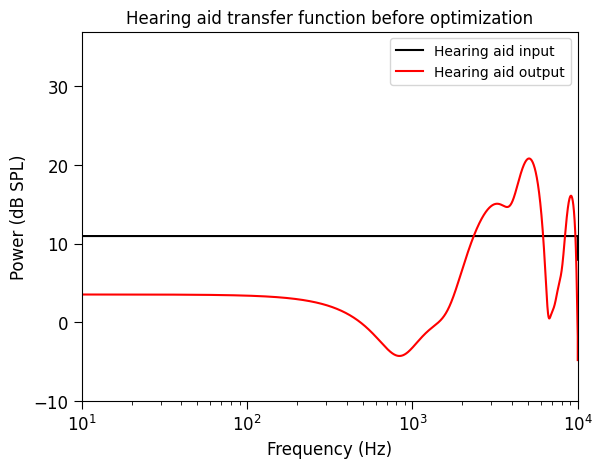

In [33]:
# hearing_aid = ConvolutionalHearingAid().to(device)
hearing_aid = ConvTasNetHearingAid().to(device)
print("`hearing_aid` parameters:")
for n, p in hearing_aid.named_parameters():
    print("|__", n, p.shape)

impulse_response_torch = hearing_aid(impulse_torch[None, ...])[0]
impulse_response = impulse_response_torch.detach().cpu().numpy()

fig, ax = plt.subplots()
fxx, pxx = utils.periodogram(impulse_numpy, sr)
fyy, pyy = utils.periodogram(impulse_response, sr)
ax.plot(fxx, pxx, color="k", label="Hearing aid input")
ax.plot(fyy, pyy, color="r", label="Hearing aid output")
ax.legend()
utils.format_axes(
    ax,
    xscale="log",
    xlimits=[10, sr / 2],
    ylimits=[-10, None],
    str_xlabel="Frequency (Hz)",
    str_ylabel="Power (dB SPL)",
    str_title="Hearing aid transfer function before optimization",
)
plt.show()


In [34]:
# Define the dataset (for time, we use only a small batch of speech signals)
x = np.stack(
    [sf.read("data/{:03d}.wav".format(_))[0] for _ in range(1)],
    axis=0,
)
x = torch.as_tensor(x, device=device, dtype=torch.float32)
print(f"Dataset shape: {x.shape}")

# Define a PyTorch optimizer object and tell it which parameters to update
optimizer = torch.optim.Adam(
    params=list(hearing_aid.parameters()),
    lr=1e-2,  # The learning rate is a hyperparameter (determines gradient descent step size)
)

# In the optimization loop, we iteratively compute the loss,
# calculate the gradients with `loss.backward()`, and then
# call `optimizer.step()` to update the parameters.
progress_bar = tqdm.tqdm(range(500))
for step in progress_bar:
    optimizer.zero_grad()
    x_aided = hearing_aid(x)
    loss = loss_function(x=x, x_aided=x_aided)
    loss.backward()
    optimizer.step()
    progress_bar.set_postfix({"loss": "{:0.4f}".format(loss.item())})


Dataset shape: torch.Size([1, 40000])


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:55<00:00,  9.09it/s, loss=372.5187]


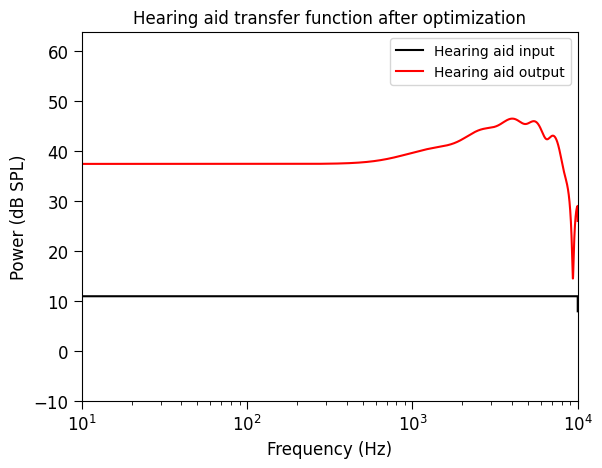

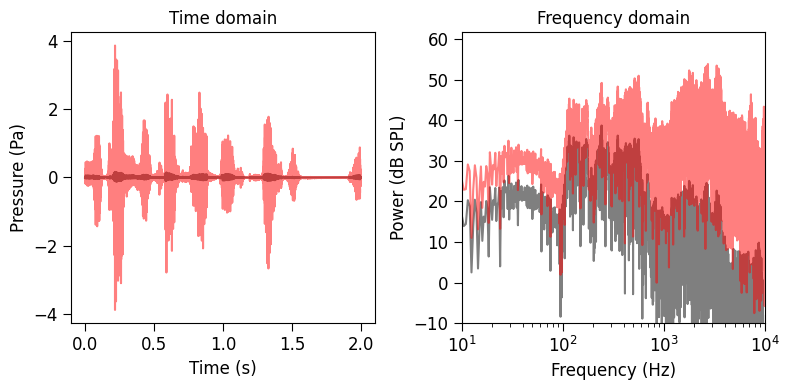

In [35]:
impulse_response_torch = hearing_aid(impulse_torch[None, ...])[0]
impulse_response = impulse_response_torch.detach().cpu().numpy()

fig, ax = plt.subplots()
fxx, pxx = utils.periodogram(impulse_numpy, sr)
fyy, pyy = utils.periodogram(impulse_response, sr)
ax.plot(fxx, pxx, color="k", label="Hearing aid input")
ax.plot(fyy, pyy, color="r", label="Hearing aid output")
ax.legend()
utils.format_axes(
    ax,
    xscale="log",
    xlimits=[10, sr / 2],
    ylimits=[-10, None],
    str_xlabel="Frequency (Hz)",
    str_ylabel="Power (dB SPL)",
    str_title="Hearing aid transfer function after optimization",
)
plt.show()

example_audio = torch.as_tensor(
    sf.read("data/000.wav".format(_))[0][None, :],
    device=device,
    dtype=torch.float32,
)

example_audio_aided = hearing_aid(example_audio)
example_audio = example_audio[0].detach().cpu().numpy()
example_audio_aided = example_audio_aided[0].detach().cpu().numpy()

fig, ax_arr = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
t = np.arange(0, len(example_audio)) / sr
ax_arr[0].plot(t, example_audio, color="k", alpha=0.5)
ax_arr[0].plot(t, example_audio_aided, color="r", alpha=0.5)
ax_arr[0] = utils.format_axes(
    ax_arr[0],
    str_xlabel="Time (s)",
    str_ylabel="Pressure (Pa)",
    str_title="Time domain",
)
fxx, pxx = utils.periodogram(example_audio, sr)
fyy, pyy = utils.periodogram(example_audio_aided, sr)
ax_arr[1].plot(fxx, pxx, color="k", alpha=0.5)
ax_arr[1].plot(fyy, pyy, color="r", alpha=0.5)
ax_arr[1] = utils.format_axes(
    ax_arr[1],
    xscale="log",
    xlimits=[10, sr / 2],
    ylimits=[-10, None],
    str_xlabel="Frequency (Hz)",
    str_ylabel="Power (dB SPL)",
    str_title="Frequency domain",
)
plt.tight_layout()
plt.show()

ipd.display(ipd.Audio(rate=sr, data=example_audio))
ipd.display(ipd.Audio(rate=sr, data=example_audio_aided))


Healthy cochlear model with unprocessed input


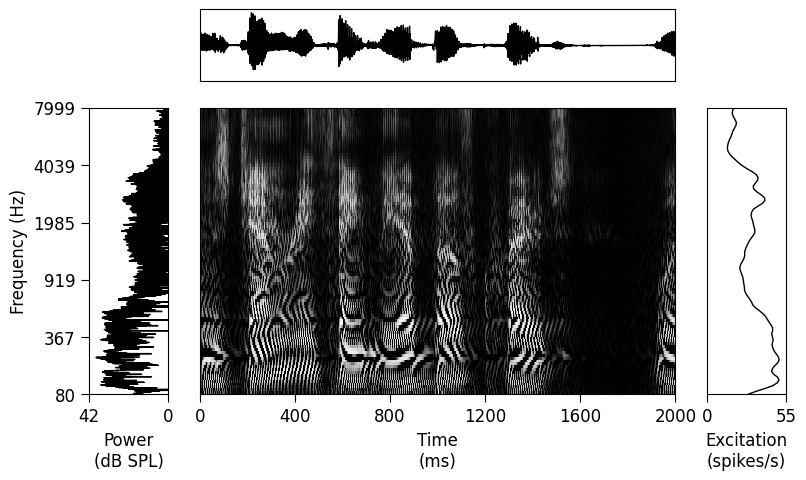

Impaired cochlear model with aided input


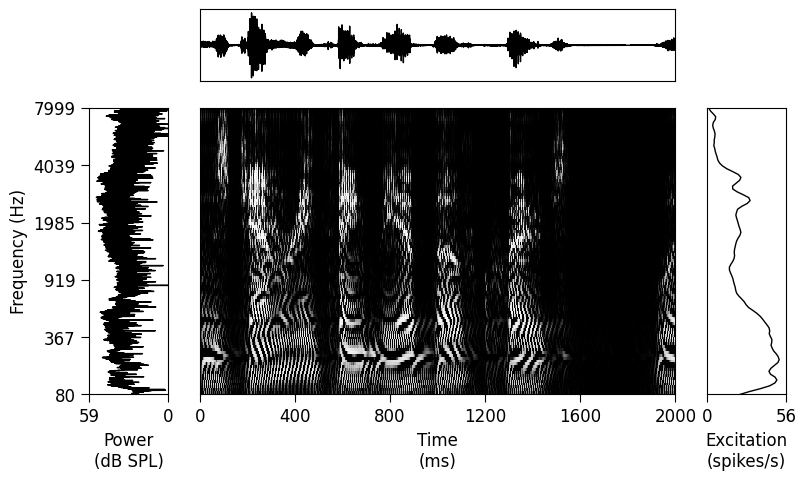

In [36]:
x, _ = sf.read("data/000.wav")

x = torch.as_tensor(x[None, ...], device=device, dtype=torch.float32)
x_aided = hearing_aid(x)
x_nervegram_healthy = cochlear_model_healthy(x)[0].detach().cpu().numpy()
x_nervegram_impaired = cochlear_model_impaired(x)[0].detach().cpu().numpy()
x_nervegram_impaired_aided = cochlear_model_impaired(x_aided)[0].detach().cpu().numpy()
x = x[0].detach().cpu().numpy()
x_aided = x_aided[0].detach().cpu().numpy()

print("Healthy cochlear model with unprocessed input")
fig, ax_arr = utils.make_nervegram_plot(
    waveform=x,
    nervegram=x_nervegram_healthy,
    sr_waveform=cochlear_model_healthy.sr_input,
    sr_nervegram=cochlear_model_healthy.sr_output,
    cfs=cochlear_model_healthy.cfs,
)
plt.show()
print("Impaired cochlear model with aided input")
fig, ax_arr = utils.make_nervegram_plot(
    waveform=x_aided,
    nervegram=x_nervegram_impaired_aided,
    sr_waveform=cochlear_model_impaired.sr_input,
    sr_nervegram=cochlear_model_impaired.sr_output,
    cfs=cochlear_model_impaired.cfs,
)
plt.show()
